### Cài đặt thư viện

In [3]:
!pip install -U langchain==0.3.24 langchain-openai==0.3.14 langgraph==0.3.33 langchain-tavily==0.1.6

In [ ]:
# Install libs
import os
os.environ["LANGCHAIN_API_KEY"] = ### Your-key
os.environ["LANGCHAIN_PROJECT"] = "Reasoning-Agent"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["TAVILY_API_KEY"] = ### Your-key
os.environ["OPENAI_API_KEY"] = ### Your-key

from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

### Định nghĩa các công cụ

In [5]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage

@tool
def triple(num: float)-> float:
    """
    :param num: a number to triple
    :return: the number tripled-> multiplied by 3
    """
    return 3 * float(num)


tools = [TavilySearch(max_results=1), triple]

system_prompt = SystemMessage(
    """
    You are a reasoning agent. Always think step-by-step.

    Use the following format:

    Thought: what you are thinking
    Action: the action to take, e.g. ‘search‘, ‘calculate‘
    Action Input: the input to the action
    Observation: the result of the action

    (Repeat Thought/Action/Observation if needed)

    Final Answer: your answer to the user

    Question: {input}
    """
)

model = ChatOpenAI(model="gpt-4.1-nano")

### Xây dựng các hàm thực hiện các tác vụ

In [6]:
import json
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
            content=json.dumps(tool_result),
            name=tool_call["name"],
            tool_call_id=tool_call["id"],
        )
    )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

### Xây dựng đồ thị

In [7]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as agent. This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use ‘agent‘.
    # This means these are the edges taken after the ‘agent‘ node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next
    should_continue,
    {
        "continue": "tools", # If ‘tools‘, then we call the tool node.
        "end": END, # Otherwise we finish.
    },
)

# We now add a normal edge from ‘tools‘ to ‘agent‘.
# This means that after ‘tools‘ is called, ‘agent‘ node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

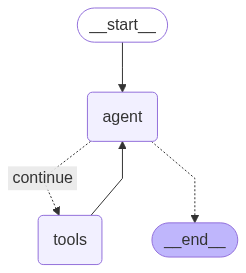

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Kiểm tra

In [10]:
inputs = {"messages": [("user", "what is the weather in vietnam? Then Triple it ")]}

for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

what is the weather in vietnam? Then Triple it 


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}